* S346175 - Hans Herman Berg
* S344080 - Björn Robert Pettersson

In [242]:
import math
import datetime
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [243]:
#Load the data

# Oct. 25th 2020 -> Oct. 25th 2021
url = 'https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=1603584000&period2=1635120000&interval=1d&events=history&includeAdjustedClose=true'

df = pd.read_csv(url, sep=',')

In [244]:
# Convert Date to Datetime
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")

In [245]:
# Check if current date (c) is 1 day after previous date (p)
def is_next_day(p, c):
  p_nextday = p + datetime.timedelta(days=1) # Increment previous date by 1 day
  return (p_nextday == c) # If the same day, return true

In [246]:
# There is no closing price for saturdays and sundays
# Fridays closing price will be duplicated for saturdays and sundays

# Loop through all rows
ci = 1 # current index
while ci < len(df):
  pi = ci - 1 # previous index
  p_row = df.iloc[pi] # previous row
  c_row = df.iloc[ci] # current row

  # Check if we have to insert a duplicate
  if(is_next_day(p_row['Date'], c_row['Date'])):
    # Check if we are within the bounds of the dataframe
    if(ci + 1 < len(df)):
      ci+=1 # move to next day
    else:
      # No more rows
      break
  else:
    # Insert duplicate of previous row
    # copy previous row and increment date by 1 day
    new_row = p_row.copy()
    new_row['Date'] = p_row['Date'] + datetime.timedelta(days=1)
    # insert into dataframe, sort by date,
    # and reset index to put new row at correct index
    df = df.append(new_row) 
    df = df.sort_values(by='Date').reset_index(drop=True)

In [247]:
# Create sets for training and prediction
df = df[['Close']]
test_fraction = 0.2;
test_days = math.floor(len(df) * test_fraction);
df['Prediction'] = df[['Close']].shift(-test_days)

# Define x and y
x = np.array(df.drop(['Prediction'], 1))[:-test_days]
y = np.array(df['Prediction'])[:-test_days]

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_fraction)

x_future = df.drop(['Prediction'], 1)[:-test_days]
x_future = x_future.tail(test_days)
x_future = np.array(x_future)

In [248]:
# Predict closing price for test set using Decision Tree Regressor
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
dtr_prediction = dtr.predict(x_future)

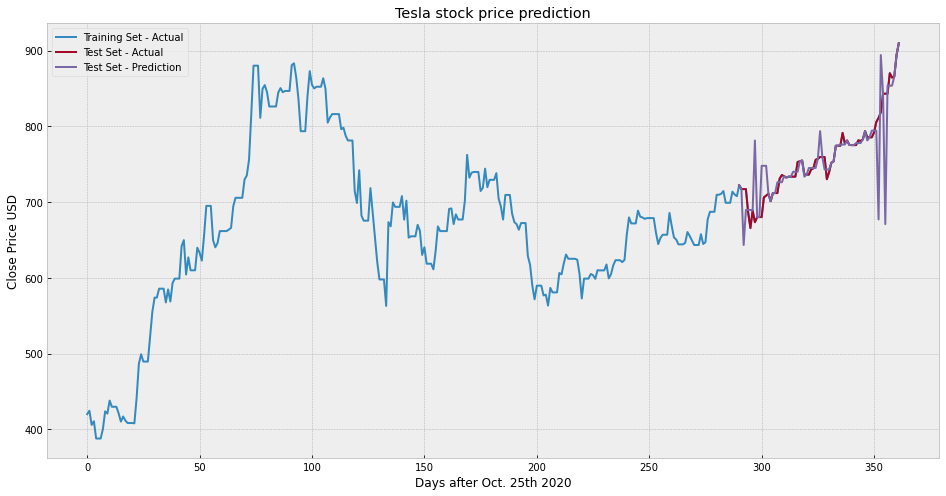

In [249]:
test_set = df[x.shape[0]:].copy()
test_set['Prediction'] = dtr_prediction

plt.figure(figsize=(16,8))
plt.title('Tesla stock price prediction')
plt.xlabel('Days after Oct. 25th 2020')
plt.ylabel('Close Price USD')
plt.plot(df['Close'])
plt.plot(test_set[['Close', 'Prediction']])
plt.legend(['Training Set - Actual', 'Test Set - Actual', 'Test Set - Prediction'])
plt.show()

In [250]:
# Prediction Accuracy
# Scoring our trained algorithm on the training set
prediction_score = dtr.score(x_train, y_train)
print("Prediction Score: "+str(prediction_score))

Prediction Score: 98.05252614057885
